In [ ]:
!pip install keract

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import warnings 
warnings.filterwarnings("ignore")

from keras import optimizers
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, Concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import *
from keras.applications.vgg19 import *
from keras.utils import plot_model
from keract import get_activations

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1
    plt.show()

In [ ]:
x_train = []
x_test = []
y_train = []
label_map = {"pneumonia":0,"corona":1}

In [ ]:
from glob import glob
images_per_class = {}
for class_folder_name in os.listdir("/content/drive/My Drive/dataset/train/"):
    class_folder_path = os.path.join("/content/drive/My Drive/dataset/train/", class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in tqdm(glob(os.path.join(class_folder_path, "*.jpg"))):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

100%|██████████| 89/89 [00:25<00:00,  3.54it/s]


In [ ]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

corona -> 89
pneumonia -> 89


In [ ]:
# for label in  label_map:
#     print(label)
#     plot_for_class(label)

In [ ]:
dim = 224

In [ ]:
dirs = os.listdir("/content/drive/My Drive/dataset/train/")
for k in range(len(dirs)):    # Directory
    files = os.listdir("/content/drive/My Drive/dataset/train/{}".format(dirs[k]))
    for f in tqdm(range(len(files))):     # Files
        img = cv2.imread('/content/drive/My Drive/dataset/train/{}/{}'.format(dirs[k], files[f]))
        targets = np.zeros(2)
        targets[label_map[dirs[k]]] = 1 
        x_train.append(cv2.resize(img, (dim, dim)))
        y_train.append(targets)

100%|██████████| 89/89 [00:02<00:00, 36.19it/s]


In [ ]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

(178, 224, 224, 3)
(178, 2)


### Mobile Net

In [ ]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(x_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = x_train[train_index], x_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 160 for training and 18 for validation


In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255)
                                      
weights = os.path.join('', 'weightsinception3.h5')

In [ ]:
# from matplotlib import pyplot 

# for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
# 	# create a grid of 3x3 images
# 	for i in range(0, 9):
# 		pyplot.subplots(330 + 1 + i)
# 		pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
# 	# show the plot
# 	pyplot.show()
# 	break


In [ ]:
epochs = 50
learning_rate = 0.0001
batch_size = 32

In [ ]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=15, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,verbose=0, mode='auto')]

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
base_model=MobileNet(input_shape=(dim, dim, 3), weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model = InceptionV3(input_shape=(dim, dim, 3), include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
x = base_model.output

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.2)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.2)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds = Dense(2, activation='sigmoid')(x)
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [ ]:
# activations = get_activations(model, x_train, auto_compile=True)
# keract.display_heatmaps(activations, input_image, save=False)

In [ ]:
# model.load_weights('/content/drive/My Drive/dataset/Best Model/Mobilenet2.h5')
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    validation_steps=len(x_valid)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs)

Epoch 1/50
5/5 [==============================] - 21s 4s/step - loss: 0.6986 - accuracy: 0.5250 - val_loss: 0.7276 - val_accuracy: 0.4444


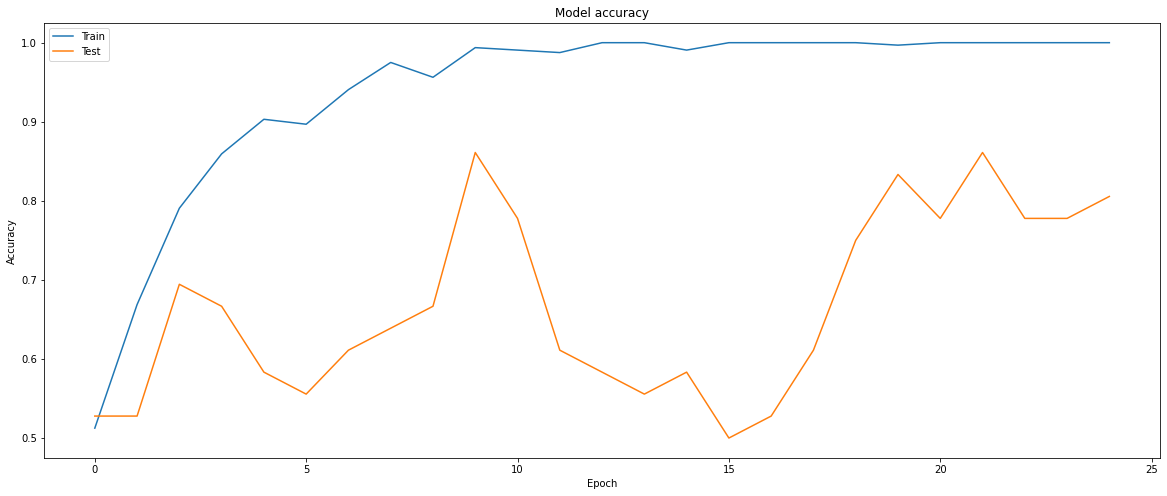

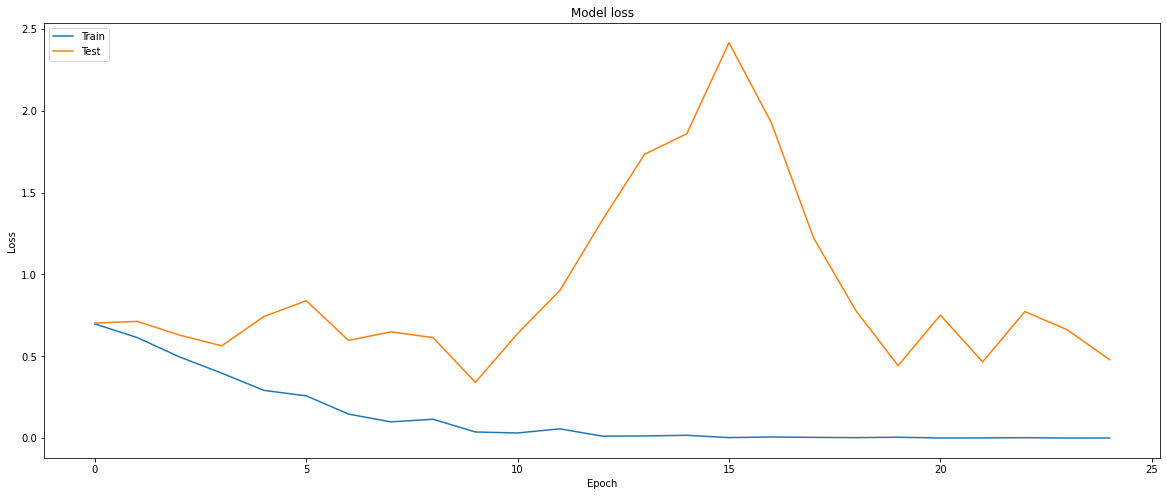

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
results = pd.DataFrame(history.history)
results.sort_values('val_loss', inplace=True)
results
#  results.to_csv("/content/drive/My Drive/dataset/result_mobilenet50_2.csv", index=False)

,val_loss,val_accuracy,loss,accuracy,lr
6,0.156607,0.916667,0.000888,1.000000,1.000000e-05
0,0.315637,0.833333,0.001164,1.000000,1.000000e-05
10,0.317678,0.833333,0.001456,1.000000,1.000000e-05
7,0.334445,0.888889,0.000578,1.000000,1.000000e-05
3,0.341252,0.888889,0.007122,0.996875,1.000000e-05
17,0.369703,0.861111,0.000725,1.000000,1.000000e-06
14,0.432697,0.861111,0.000925,1.000000,1.000000e-05
12,0.459952,0.777778,0.001734,1.000000,1.000000e-05
8,0.464968,0.888889,0.004668,1.000000,1.000000e-05
16,0.469383,0.833333,0.000751,1.000000,1.000000e-05


In [ ]:
# import matplotlib.pyplot as plt
# def plot_model(model):
#     plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
#     plt.figure(figsize=(10,10))

#     for i, p in enumerate(plots):
#         plt.subplot(len(plots), 2, i + 1)
#         plt.title(p)
#         plt.plot(model.history.history[p], label=p)
#         plt.plot(model.history.history['val_'+p], label='val_'+p)
#         plt.legend()
#         plt.savefig(f'/content/drive/My Drive/Result Analysis/{i}.jpg')

#     plt.show()
    
# plot_model(model)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# from keras.models import load_model

# model = load_model('/content/drive/My Drive/dataset/Best Model/Mobilenet2.h5')

In [ ]:
validation_generator = datagen.flow(x_valid, y_valid)
y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1])

In [ ]:
model.evaluate_generator(validation_generator, verbose=1)

1/1 [==============================] - 0s 79ms/step


[0.6063888072967529, 0.8333333134651184]